# Modeling

In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, LassoCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('andrey_4_2023_10_25.csv')
data['day'] = pd.to_datetime(data.day, format='%d/%m/%y')
data.drop(data[data.days_offline.isna()].index, inplace=True)

alldays = sorted(data.day.unique())

data['activitydunamic_7'] = (data['active_7'] / data['active_14']).replace([np.inf, -np.inf], np.nan).fillna(0)
data['activitydunamic_14'] = (data['active_14'] / data['active_21']).replace([np.inf, -np.inf], np.nan).fillna(0)
data = data[(data.day >= alldays[14])&(data.day < alldays[-14])]

In [4]:
def tscv(data, alldays=alldays, test_size=20, k_folds=3):
    """cv for time based data
    """
    for k in range(k_folds):
        threshold = alldays[123 + (k - k_folds) * test_size]
        yield threshold

In [5]:
features = ['max_off_period',
            'days_offline',
            'sum_success_14d', 
            'solved_total',
            'avg_submits_14d', 
            'active_7', 
            'activitydunamic_7',
            'level_1', 'level_2', 'level_3' 
           ]

model = LogisticRegression()
model = LogisticRegression(penalty='l2', C=.6)
for threshold in tscv(data): 
    data_train, data_test = data[data.day <= threshold], data[data.day > threshold]
    X_train = data_train.loc[:, features]
    y_train = data_train.target_14d
    X_test = data_test.loc[:, features]
    y_test = data_test.target_14d
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    print(f'test roc-auc: {roc_auc_score(y_test, y_pred)}, train roc-auc: {roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])}')

test roc-auc: 0.9064271513774494, train roc-auc: 0.9162650660264106
test roc-auc: 0.9141384158081126, train roc-auc: 0.914764888337469
test roc-auc: 0.9211339448671456, train roc-auc: 0.9149711270173891


In [257]:
# full data
model = LogisticRegression(penalty='l2', C=.6)
X_train = data.loc[:, features]
y_train = data.target_14d
clf = model.fit(X_train, y_train)

In [271]:
# SQL regressin

sql_regression = ''
for f, c in zip(features, clf.coef_[0]):
    sign = np.sign(c)
    if sign == -1:
        sign = '-'
    else:
        sign = '+'
    sql_regression += sign + ' ' + str(round(np.abs(c), 7)) + ' * ' + f + ' '
if sql_regression[0] == '+':
    sql_regression = sql_regression[2:-1]
else:
    sql_regression = sql_regression[:-1]
    
sql_regression

'0.0502885 * max_off_period - 0.0252817 * days_offline + 0.2131352 * sum_success_14d - 0.096108 * solved_total - 1.4088518 * avg_submits_14d - 0.7415142 * active_14 + 0.0064787 * activitydunamic_7 + 0.1036307 * level_1 - 0.4317148 * level_2 - 1.6168342 * level_3'

# Bootstrapping

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(context='notebook')

from bootstrap import roc_auc_ci, pr_curve, pr_threshold, sr_curve, sr_threshold

import warnings
warnings.filterwarnings('ignore')

In [293]:
%%time
bounds, samples_roc_auc = roc_auc_ci(clf,
    X_test.values,
    y_test.values,
    n_bootstraps= 10000,
    samples_out=True
)

bounds

CPU times: user 33.7 s, sys: 734 ms, total: 34.5 s
Wall time: 34.5 s


array([0.91078592, 0.93108716])

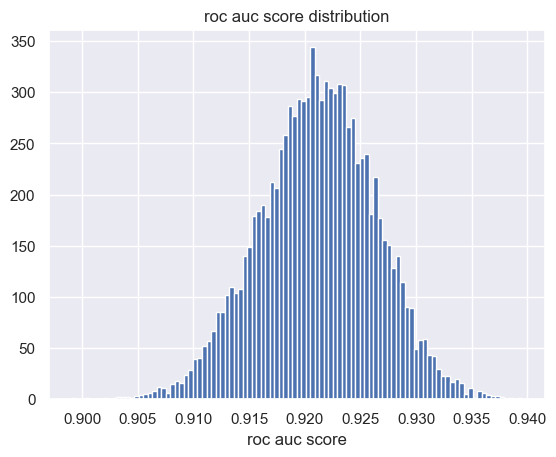

In [294]:
plt.hist(samples_roc_auc, bins=100)
plt.xlabel('roc auc score')
plt.title('roc auc score distribution')
plt.show()

In [10]:
y = y_test.values
indices = list(np.arange(y.shape[0])[y_test==1])
indices += list(np.random.choice(np.arange(y_test.shape[0])[y==0], 500))

y_pred = clf.predict_proba(X_test.values[indices])[:, 1]
y = y[indices]
idx = np.argsort(y_pred)[::-1]
y_pred = y_pred[idx]
y = y[idx]

roc_auc_score(y, y_pred)

0.9180139372822299

In [11]:
%%time
recall, precision, precision_lcb, precision_ucb = pr_curve(y, y_pred, n_bootstrap = 10000)

CPU times: user 1.08 s, sys: 26 ms, total: 1.1 s
Wall time: 1.1 s


Text(0.5, 1.0, 'Precision-Recall')

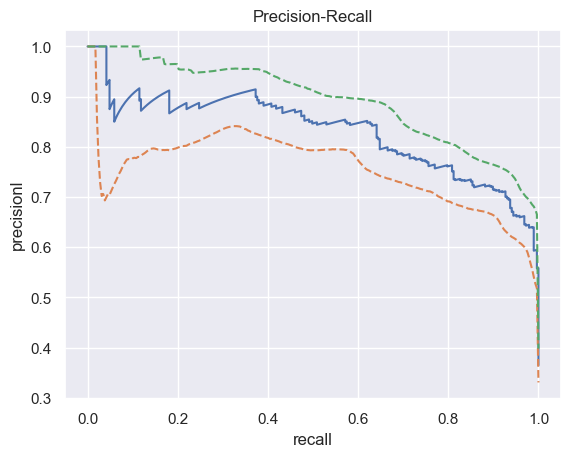

In [12]:
plt.plot(recall, precision)
plt.plot(recall, precision_lcb, '--')
plt.plot(recall, precision_ucb, '--')
plt.xlabel('recall')
plt.ylabel('precisionl')
plt.title('Precision-Recall')

In [21]:
# recall interval unde threshold precision

pr_threshold(y, y_pred, min_precision=0.85)

(0.09826325241640815, 0.6202090592334495)

In [22]:
%%time
recall, specificity, specificity_lcb, specificity_ucb = sr_curve(y, y_pred, n_bootstrap = 10000)

CPU times: user 1.09 s, sys: 23.2 ms, total: 1.11 s
Wall time: 1.11 s


Text(0.5, 1.0, 'Sensitivity-Specificity')

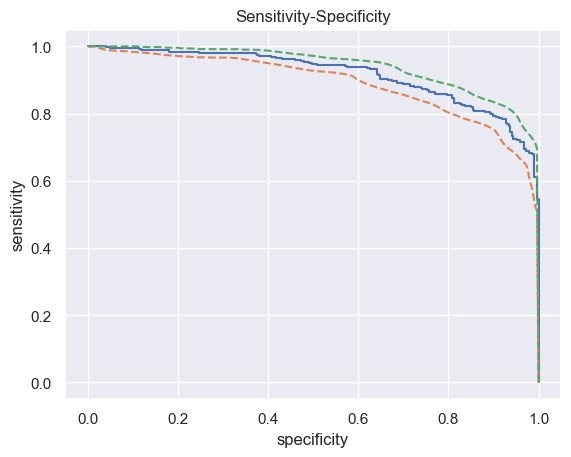

In [24]:
plt.plot(recall, specificity)
plt.plot(recall, specificity_lcb, '--')
plt.plot(recall, specificity_ucb, '--')
plt.xlabel('specificity')
plt.ylabel('sensitivity')
plt.title('Sensitivity-Specificity')

In [28]:
# sensitivity interval unde threshold specificity

sr_threshold(
    y, y_pred,
    min_specificity=0.8)

(0.02244789041967548, 0.8989547038327527)